# Linear Regression with Machine Unlearning (DeltaGrad)

This notebook demonstrates how to train a simple linear regression model, visualize its predictions, and then apply a machine unlearning technique (DeltaGrad-inspired) to erase the influence of selected data points. Visualizations are provided at each step for clarity.

## 1. Import Required Libraries
We will use numpy for data generation, matplotlib for visualization, and scikit-learn for linear regression. DeltaGrad will be implemented manually as there is no standard package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.random.seed(42)  # For reproducibility

## 2. Generate Sample Data
We will create synthetic data for a simple linear regression problem: $y = 3x + 2 + \epsilon$, where $\epsilon$ is Gaussian noise.

In [2]:
# Generate synthetic data
n_samples = 100
X = np.linspace(0, 10, n_samples).reshape(-1, 1)
noise = np.random.normal(0, 2, size=n_samples).reshape(-1, 1)
y = 3 * X + 2 + noise

## 3. Visualize Sample Data
Let's plot the generated data to see the linear relationship and noise.

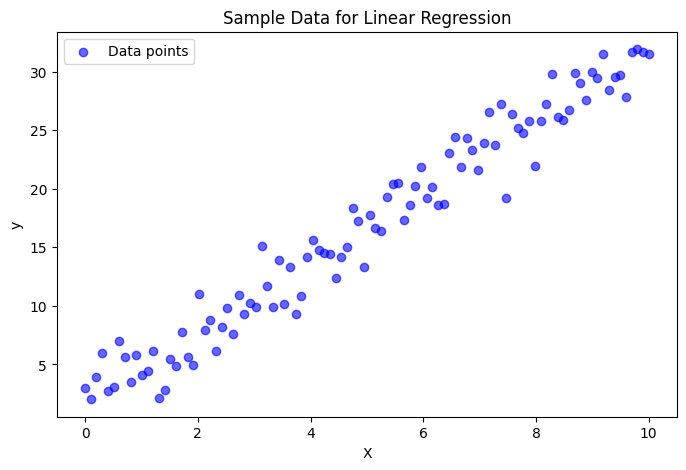

In [3]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Data points')
plt.title('Sample Data for Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## 4. Train Linear Regression Model
We will fit a linear regression model to the data using scikit-learn.

In [4]:
# Train linear regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(f"Model coefficients: w = {model.coef_[0][0]:.3f}, b = {model.intercept_[0]:.3f}")

Model coefficients: w = 3.028, b = 1.654


## 5. Visualize Model Predictions
Let's plot the regression line along with the data points to see how well the model fits.

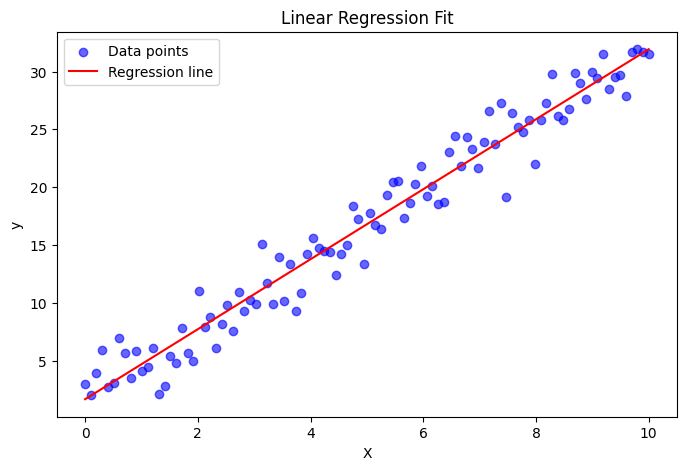

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Data points')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.title('Linear Regression Fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## 6. Select Data Points to Erase
We will randomly select a subset of data points to be erased (unlearned) and highlight them in the plot.

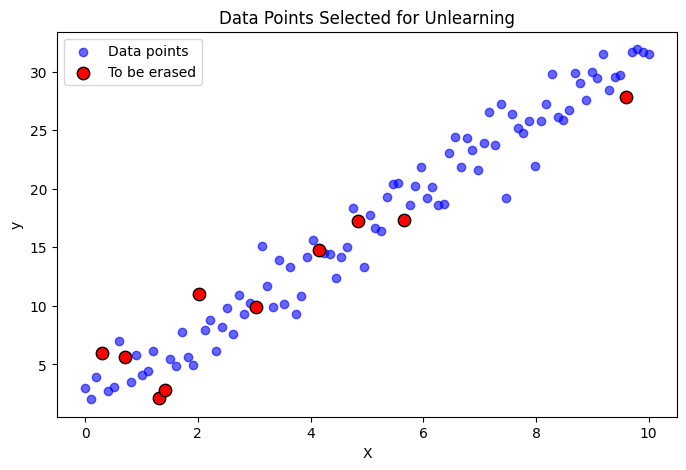

In [6]:
# Select random indices to erase
n_erase = 10
erase_indices = np.random.choice(n_samples, n_erase, replace=False)

# Plot and highlight points to erase
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.6, label='Data points')
plt.scatter(X[erase_indices], y[erase_indices], color='red', label='To be erased', s=80, edgecolor='black')
plt.title('Data Points Selected for Unlearning')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## 7. Apply Machine Unlearning (DeltaGrad)
We will implement a simple DeltaGrad-inspired update. For linear regression, the closed-form solution is $\theta = (X^T X)^{-1} X^T y$. We will update the model parameters by removing the contribution of the erased points from the sufficient statistics, instead of retraining from scratch.

In [7]:
# DeltaGrad-inspired unlearning for linear regression (closed-form update)
# Remove erased points from sufficient statistics
X_full = np.hstack([np.ones_like(X), X])  # Add bias term
X_erase = X_full[erase_indices]
y_erase = y[erase_indices]

# Compute sufficient statistics
XtX = X_full.T @ X_full
Xty = X_full.T @ y

# Remove erased points' contribution
XtX_unlearn = XtX - X_erase.T @ X_erase
Xty_unlearn = Xty - X_erase.T @ y_erase

# Compute new parameters
w_unlearn = np.linalg.inv(XtX_unlearn) @ Xty_unlearn
print(f"Unlearned model coefficients: w = {w_unlearn[1,0]:.3f}, b = {w_unlearn[0,0]:.3f}")

y_pred_unlearn = X_full @ w_unlearn

Unlearned model coefficients: w = 3.057, b = 1.525


## 8. Retrain Model After Unlearning (For Comparison)
Now, let's retrain the model from scratch on the reduced dataset (with erased points removed) to compare with the DeltaGrad-inspired update.

In [8]:
# Remove erased points from data
mask = np.ones(n_samples, dtype=bool)
mask[erase_indices] = False
X_reduced = X[mask]
y_reduced = y[mask]

# Retrain model
model_retrained = LinearRegression()
model_retrained.fit(X_reduced, y_reduced)
y_pred_retrained = model_retrained.predict(X)
print(f"Retrained model coefficients: w = {model_retrained.coef_[0][0]:.3f}, b = {model_retrained.intercept_[0]:.3f}")

Retrained model coefficients: w = 3.057, b = 1.525


## 9. Visualize Model After Unlearning
Let's plot the regression lines after unlearning (DeltaGrad-inspired) and after retraining, along with the original model for comparison.

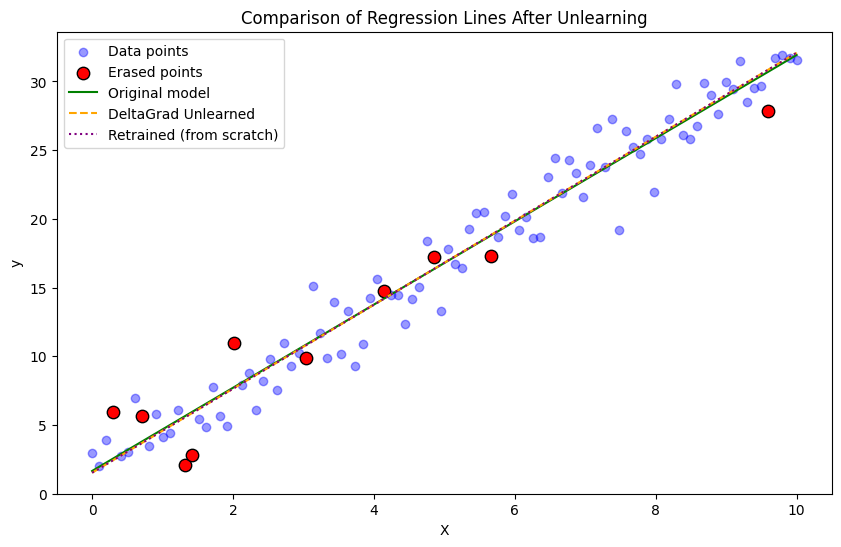

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.4, label='Data points')
plt.scatter(X[erase_indices], y[erase_indices], color='red', label='Erased points', s=80, edgecolor='black')
plt.plot(X, y_pred, color='green', label='Original model')
plt.plot(X, y_pred_unlearn, color='orange', linestyle='--', label='DeltaGrad Unlearned')
plt.plot(X, y_pred_retrained, color='purple', linestyle=':', label='Retrained (from scratch)')
plt.title('Comparison of Regression Lines After Unlearning')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## 10. Compare Model Before and After Unlearning
Let's compare the model parameters and predictions before and after unlearning, and discuss the differences.

In [11]:
print("Original model:     w = {:.3f}, b = {:.3f}".format(model.coef_[0][0], model.intercept_[0]))
print("DeltaGrad unlearn:  w = {:.3f}, b = {:.3f}".format(w_unlearn[1,0], w_unlearn[0,0]))
print("Retrained model:    w = {:.3f}, b = {:.3f}".format(model_retrained.coef_[0][0], model_retrained.intercept_[0]))

mse_orig = mean_squared_error(y, y_pred)
mse_unlearn = mean_squared_error(y, y_pred_unlearn)
mse_retrain = mean_squared_error(y, y_pred_retrained)

print(f"\nMSE (Original): {mse_orig:.2f}")
print(f"MSE (DeltaGrad Unlearned): {mse_unlearn:.2f}")
print(f"MSE (Retrained): {mse_retrain:.2f}")


Original model:     w = 3.028, b = 1.654
DeltaGrad unlearn:  w = 3.057, b = 1.525
Retrained model:    w = 3.057, b = 1.525

MSE (Original): 3.26
MSE (DeltaGrad Unlearned): 3.27
MSE (Retrained): 3.27
